# middle research data-science 202055133 성강


## 주제: 질문 대답 소요 시간을 기반으로 투표율의 분석  

------------------

### 1. 탐구 동기
- 최근에 재보궐 선거가 있었고, 활성화 인터넷 심리검사 사람의 심리와 투표율간의 상관관계를 알고 싶다는 생각을 하게 되었고, 우연히 dacon에서 외국의 데이터이긴하지만, 심리검사와 사람의 특성을 기반으로 투표를 했는지에 대한 여부를 나타낸 데이터가 있었기에 분석을 진행해보고자 하였다. 
- 또한 심리검사 데이터를 기반으로 하면 향후 심리검사 질문의 특성, 응답 소요 시간을 기반으로 하여 투표율을 예측할 수도 있을 것이라는 기대를 하고 탐구를 시작하게 되었다.   

----------------

### 2. 가설
- 본 탐구에서는 특이하게 튀는 값들을 제외하고는, 질문에 대답하는데 걸리는 시간이 길다는 것이 신중한 사람이라는 것을 나타낼 수 있는 지표중 하나라고 생각하고 아래와 같은 가설을 세웠다.
- **질문에 대답하는 시간이 길수록 투표율이 높아질 것이다.**
    - 이때 질문을 nlu 기반으로 3가지 그룹으로 나누고, 각 그룹으로 걸린 시간으로 분배해서도 분석해보고자 한다.
    - 질문을 답하는 시간이 정규분포를 따를 것으로 기대한다.
----------

### 3. 탐구 과정 및 결과
#### 1) import module

In [1]:
import numpy as np
import numpy.random as random
import scipy as sp
import scipy.stats as stats
import pandas as pd
from pandas import Series, DataFrame

# 시각화 라이브러리
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker
import seaborn as sns
%matplotlib inline

# 소수점 3자리까지 표시
%precision 3

'%.3f'

In [2]:
# nlu를 위한 module를 import한다.
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to /Users/seong-
[nltk_data]     gang/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


#### 2) data loding
- 처음에는 train dataset, test dataset을 다 쓸수 있을 것으로 기대하였지만, test dataset에는 voted 데이터가 빠져있기 때문에 사용하지 못했다.

In [3]:
data = pd.read_csv("./open data/train.csv")
data

,index,QaA,QaE,QbA,QbE,QcA,QcE,QdA,QdE,QeA,...,wr_04,wr_05,wr_06,wr_07,wr_08,wr_09,wr_10,wr_11,wr_12,wr_13
0,0,3.0,363,4.0,1370,5.0,997,1.0,1024,2.0,...,0,1,0,1,1,0,1,0,1,1
1,1,5.0,647,5.0,1313,3.0,3387,5.0,2969,1.0,...,1,1,0,1,1,0,1,0,1,1
2,2,4.0,1623,1.0,1480,1.0,1021,4.0,3374,5.0,...,1,1,0,1,1,1,1,0,1,1
3,3,3.0,504,3.0,2311,4.0,992,3.0,3245,1.0,...,0,0,0,0,1,0,1,0,1,1
4,4,1.0,927,1.0,707,5.0,556,2.0,1062,1.0,...,1,1,1,1,1,0,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45527,45527,2.0,1050,5.0,619,4.0,328,1.0,285,1.0,...,1,1,0,1,1,1,1,0,1,1
45528,45528,2.0,581,3.0,1353,4.0,1164,1.0,798,3.0,...,1,1,0,1,1,1,1,0,1,1
45529,45529,4.0,593,1.0,857,1.0,1047,4.0,1515,5.0,...,1,1,0,1,1,0,1,0,1,1
45530,45530,1.0,747,3.0,1331,4.0,892,2.0,1281,1.0,...,1,1,0,1,1,1,1,0,1,1


#### 3) getting time data
- Q_E라는 요소를 활용한다.
    - 이는 초 단위는 아니지만, 상대적인 변수이기 때문에, 그 값이 클수록 문제를 답하는데 시간이 오래걸렸다고 볼 수 있을 듯 하다.

In [4]:
time_answer_list = [f"Q{i}E" for i in "abcdefghijklmnopqrst"]
time_answer = data[time_answer_list]
time_answer

,QaE,QbE,QcE,QdE,QeE,QfE,QgE,QhE,QiE,QjE,QkE,QlE,QmE,QnE,QoE,QpE,QqE,QrE,QsE,QtE
0,363,1370,997,1024,1577,539,586,1095,1142,1287,883,851,851,816,579,924,366,876,633,1115
1,647,1313,3387,2969,4320,2190,826,4082,1867,1264,2943,3927,4329,1828,1214,2414,1356,3039,4304,1346
2,1623,1480,1021,3374,1333,531,1167,1016,2653,1569,998,2547,918,2153,1304,1131,937,1327,1170,1409
3,504,2311,992,3245,357,1519,159,2275,2809,5614,3219,1296,9046,1216,1169,23868,581,8830,2392,1312
4,927,707,556,1062,1014,628,991,1259,1153,1388,740,1181,547,575,754,1140,323,1070,583,1889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45527,1050,619,328,285,602,267,315,483,1016,278,611,215,388,299,1915,439,823,309,586,2252
45528,581,1353,1164,798,1680,560,640,1415,4494,1392,2478,1268,843,1401,1524,719,754,1118,654,1197
45529,593,857,1047,1515,1690,1253,1094,1283,2209,1764,1062,1489,1908,891,1298,1200,473,1779,1355,667
45530,747,1331,892,1281,1328,599,650,1429,1748,770,1025,742,4180,707,489,913,1301,1680,737,1124


- 먼저 정말로 질문들에 대한 대답이 정규분포와 같은 납득이 가능한 분포를 이루는지 확인하는 과정을 거친다.

In [5]:
time_a = time_answer[["QaE"]]
time_a

,QaE
0,363
1,647
2,1623
3,504
4,927
...,...
45527,1050
45528,581
45529,593
45530,747


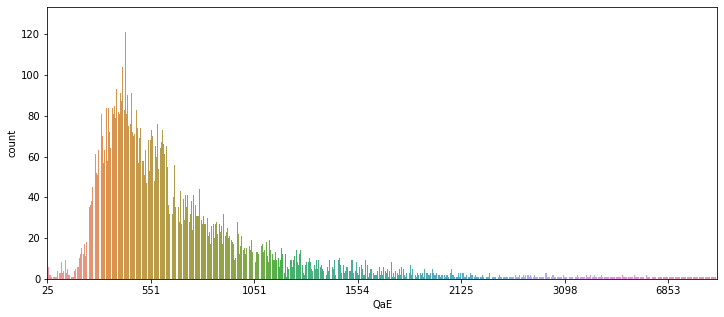

In [6]:
plt.rcParams["figure.figsize"] = (12, 5)
fig, ax = plt.subplots()
sns.countplot(x="QaE", data=time_a)
ax.xaxis.set_major_locator(ticker.MultipleLocator(500))

- 이후 QaE ~ QtE를 한번에 시각화하는 것에서도 xticks를 변화시켜줄려고했지만, 잘 되지 않았다.
    - 그러나 이 작업의 목표는 사람들이 실제로 질문에 답변하는 시간에 있어서 정규분포를 따르는지를 확인하는 일에 있기 때문에, 큰 상관이 없다고 생각, 조사를 계속하였다.
    - 아래의 코드는 실행하는데 엄청나게 긴 시간이 걸림.

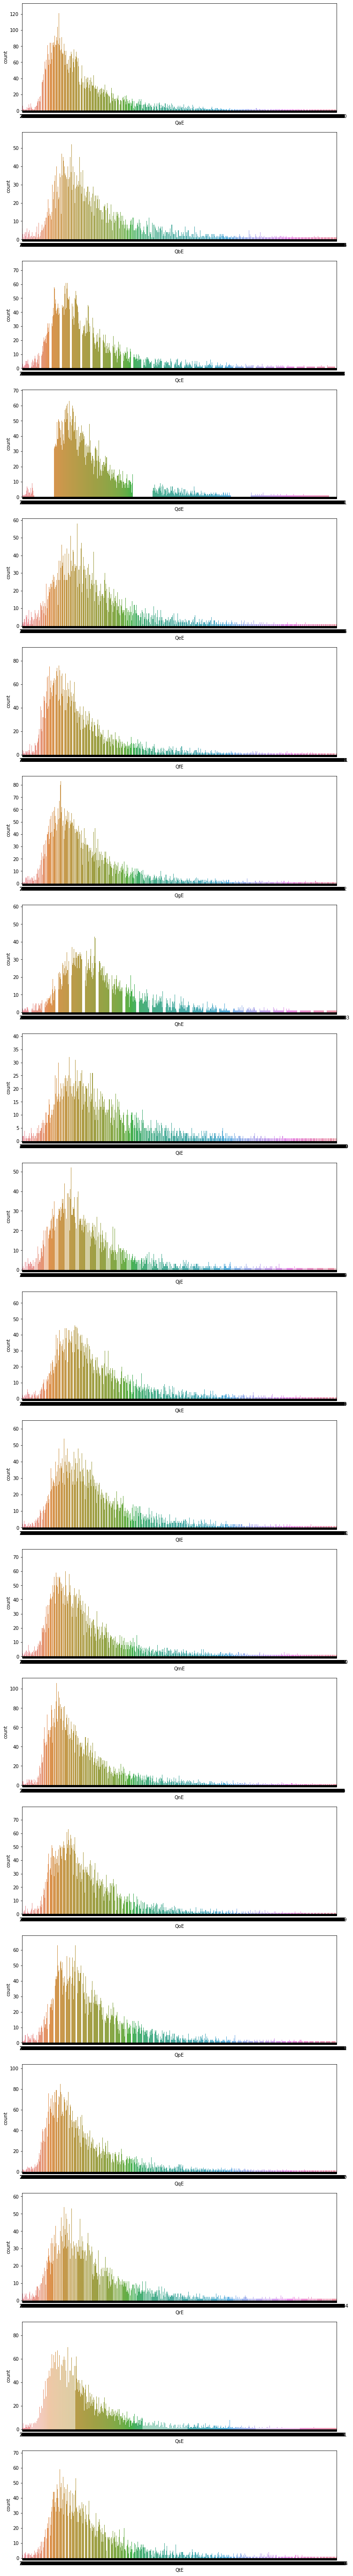

In [7]:
plt.rcParams["figure.figsize"] = (12, 100)
fig, axes = plt.subplots(20, 1)
for i in range(1,21):
    plt.subplot(20, 1, i)
    sub_data = time_answer[[time_answer_list[i-1]]]
    x = time_answer_list[i-1]
    sns.countplot(x=x, data=sub_data)

- 이렇게 정규분포를 확인하는 이유는, 내가 생각하지 못한 요소가 드러날 수 있다고 생각했기 때문이다. 그렇기에 중간에 빈 공간의 크기가 비정상적으로 큰 질문들은 제외한다.
    - 이렇게 생각하였지만, 현재 다른 노트북에서 다른 버전의 seaborn을 돌렸을 때와 그래프에 차이가 있다. 즉, 중간에 빈 값처럼 보이는 것은 너무 얇아서 빈 값으로 보이는 것이지 다르게 신경쓸 필요가 없는 것이다.

#### 4) nlu 
- 데이터를 제공해준 출처에 따르면, 사용자의 개인적인 사생활에 피해가 될 수도 있는 문제들 몇개는 secret으로 주어진다고 한다. 
- 이에 따라 secret하지 않은 질문들에 대해서는 nlu를 진행한다.
    - 단, 현재 탐구 프로젝트는 이러한 모델링을 요구하는 것이 아니기 때문에 이미 있는 유명한 module을 가져와서 해당 단계를 진행한다.
    - 차례대로 neg는 부정적인 정도, neu는 중립적인 정도, pos는 긍정적인 정도로, 3개의 합이 1이 되도록 나타난다. 이에 따라 나중에 질문별로 걸린 시간을 각각의 감정에 맞춰서 분류를 할 수 있는 것이다.
    - 추가적으로 나타나는 compound에 대한 설명을 아래와 같다. 간단하게 설명하자면, -1에서 1사이의 값으로, 하나의 숫자로만 해당 문장을 분석해야할 때, 사용하는 지표이다. -1은 부정적인 것, 1은 긍정적인 것이다. 하지만 본 연구에서는 사용하지 않는 값이다.
    - 솔직히 말해서 완전하게 마음에 드는 감정 분석은 아니었지만, 질문 자체가 3개의 카테고리만으로 정의되기에는 한계가 있는 것 같았으며, "A sentiment lexicon is a list of lexical features (e.g., words) which are generally labeled according to their semantic orientation as either positive or negative."라는 설명 처럼 보통 안에 들어있는 단어들 자체의 부정적이거나, 긍정적인 요소를 분석한듯 한 느낌이 많이 들기는 하였다.


In [8]:
sentences = ["The biggest difference between most criminals and other people is that the criminals are stupid enough to get caught.",  #Qb
            "Anyone who completely trusts anyone else is asking for trouble.", #Qc
            "P.T. Barnum was wrong when he said that there's a sucker born every minute.", #Qe
            "There is no excuse for lying to someone else.", #Qf
            "Most people forget more easily the death of their parents than the loss of their property.", #Qh
            "It is safest to assume that all people have a vicious streak and it will come out when they are given a chance.", #Qj
            "All in all, it is better to be humble and honest than to be important and dishonest", #Qk
            "It is hard to get ahead without cutting corners here and there.", #Qm
            "The best way to handle people is to tell them what they want to hear.", #Qo
            "Most people are basically good and kind.", #Qq
            "One should take action only when sure it is morally right.", #Qr
            "It is wise to flatter important people." #Qs
            ]

analyzer = SentimentIntensityAnalyzer()
for sentence in sentences:
    vs = analyzer.polarity_scores(sentence)
    print("{:-<188} {}".format(sentence, str(vs)))

The biggest difference between most criminals and other people is that the criminals are stupid enough to get caught.----------------------------------------------------------------------- {'neg': 0.416, 'neu': 0.584, 'pos': 0.0, 'compound': -0.9079}
Anyone who completely trusts anyone else is asking for trouble.----------------------------------------------------------------------------------------------------------------------------- {'neg': 0.192, 'neu': 0.568, 'pos': 0.241, 'compound': 0.1761}
P.T. Barnum was wrong when he said that there's a sucker born every minute.----------------------------------------------------------------------------------------------------------------- {'neg': 0.371, 'neu': 0.629, 'pos': 0.0, 'compound': -0.7579}
There is no excuse for lying to someone else.----------------------------------------------------------------------------------------------------------------------------------------------- {'neg': 0.434, 'neu': 0.465, 'pos': 0.101, 'compound': -0

In [9]:
nlu_question_list = [f"Q{i}E" for i in "bcefhjkmoqrs"]
nlu_rate_list = [analyzer.polarity_scores(sentence) for sentence in sentences]
nlu_rate_dict = dict(zip(nlu_question_list, nlu_rate_list))
print(nlu_rate_dict)
print(len(nlu_rate_dict) == len(sentences))

{'QbE': {'neg': 0.416, 'neu': 0.584, 'pos': 0.0, 'compound': -0.9079}, 'QcE': {'neg': 0.192, 'neu': 0.568, 'pos': 0.241, 'compound': 0.1761}, 'QeE': {'neg': 0.371, 'neu': 0.629, 'pos': 0.0, 'compound': -0.7579}, 'QfE': {'neg': 0.434, 'neu': 0.465, 'pos': 0.101, 'compound': -0.6486}, 'QhE': {'neg': 0.37, 'neu': 0.514, 'pos': 0.115, 'compound': -0.7139}, 'QjE': {'neg': 0.099, 'neu': 0.714, 'pos': 0.187, 'compound': 0.296}, 'QkE': {'neg': 0.15, 'neu': 0.526, 'pos': 0.324, 'compound': 0.5106}, 'QmE': {'neg': 0.11, 'neu': 0.783, 'pos': 0.107, 'compound': -0.0077}, 'QoE': {'neg': 0.0, 'neu': 0.703, 'pos': 0.297, 'compound': 0.6705}, 'QqE': {'neg': 0.0, 'neu': 0.442, 'pos': 0.558, 'compound': 0.743}, 'QrE': {'neg': 0.0, 'neu': 0.813, 'pos': 0.187, 'compound': 0.3182}, 'QsE': {'neg': 0.0, 'neu': 0.388, 'pos': 0.612, 'compound': 0.6486}}
True


#### 5) handling secret question
- secret한 질문들을 다룰 방법에 대해서 생각해보았다. 즉, (a, d, g, i, l, n, p, t)을 해석하는 것이다. - 버리기에는 너무나 많은 데이터라고 생각을 하였기에, 이를 접근하는 방법에 대해서 고민을 해보았다.
- 개인적으로 생각한 기법은 아래와 같다.(이때, 1일수록 해당 질문에 대하여 그렇다고 생각하는 지표이다.)
    - 사용자 별로 해당 질문에 대답한 답변(1,2,3,4,5 중 하나): a(i)
    - 사용자가 다른 질문에 대답한 답변들(1,2,3,4,5 중 하나): b(i), c(i), d(i), ...
    - (a(i) - b(i))^2의 작업을 c(i), d(i), .. 에 대해서도 진행한다.
    - 해당 작업을 모든 사용자들에 대해서한다.(a(1) ~ a(56915))
    - 그 차가 가장 적은 질문을 선택하여(b라 하자), a라는 질문에 b에 해당한 nlu 값을 할당한다.

In [10]:
data

,index,QaA,QaE,QbA,QbE,QcA,QcE,QdA,QdE,QeA,...,wr_04,wr_05,wr_06,wr_07,wr_08,wr_09,wr_10,wr_11,wr_12,wr_13
0,0,3.0,363,4.0,1370,5.0,997,1.0,1024,2.0,...,0,1,0,1,1,0,1,0,1,1
1,1,5.0,647,5.0,1313,3.0,3387,5.0,2969,1.0,...,1,1,0,1,1,0,1,0,1,1
2,2,4.0,1623,1.0,1480,1.0,1021,4.0,3374,5.0,...,1,1,0,1,1,1,1,0,1,1
3,3,3.0,504,3.0,2311,4.0,992,3.0,3245,1.0,...,0,0,0,0,1,0,1,0,1,1
4,4,1.0,927,1.0,707,5.0,556,2.0,1062,1.0,...,1,1,1,1,1,0,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45527,45527,2.0,1050,5.0,619,4.0,328,1.0,285,1.0,...,1,1,0,1,1,1,1,0,1,1
45528,45528,2.0,581,3.0,1353,4.0,1164,1.0,798,3.0,...,1,1,0,1,1,1,1,0,1,1
45529,45529,4.0,593,1.0,857,1.0,1047,4.0,1515,5.0,...,1,1,0,1,1,0,1,0,1,1
45530,45530,1.0,747,3.0,1331,4.0,892,2.0,1281,1.0,...,1,1,0,1,1,1,1,0,1,1


In [11]:
base_question_list = [f"Q{i}A" for i in "bcefhjkmoqrs"]
base_question = data[base_question_list]
base_question

,QbA,QcA,QeA,QfA,QhA,QjA,QkA,QmA,QoA,QqA,QrA,QsA
0,4.0,5.0,2.0,5.0,4.0,4.0,4.0,2.0,2.0,2.0,2.0,2.0
1,5.0,3.0,1.0,3.0,1.0,3.0,5.0,1.0,1.0,5.0,1.0,4.0
2,1.0,1.0,5.0,1.0,1.0,2.0,5.0,2.0,2.0,5.0,4.0,1.0
3,3.0,4.0,1.0,2.0,3.0,4.0,3.0,4.0,4.0,3.0,4.0,4.0
4,1.0,5.0,1.0,2.0,1.0,5.0,5.0,4.0,1.0,5.0,5.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
45527,5.0,4.0,1.0,1.0,1.0,4.0,4.0,4.0,2.0,2.0,1.0,5.0
45528,3.0,4.0,3.0,2.0,1.0,5.0,2.0,3.0,4.0,2.0,3.0,4.0
45529,1.0,1.0,5.0,4.0,1.0,1.0,5.0,1.0,1.0,5.0,5.0,3.0
45530,3.0,4.0,1.0,1.0,1.0,1.0,5.0,4.0,1.0,4.0,4.0,4.0


- 먼저 QaA로 먼저 작업이 되는지 확인한다.

In [12]:
QaA = data[["QaA"]]
QaA["b"] = (QaA["QaA"] - base_question["QbA"])**2
QaA

<ipython-input-12-ad1604d6c870>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  QaA["b"] = (QaA["QaA"] - base_question["QbA"])**2


,QaA,b
0,3.0,1.0
1,5.0,0.0
2,4.0,9.0
3,3.0,0.0
4,1.0,0.0
...,...,...
45527,2.0,9.0
45528,2.0,1.0
45529,4.0,9.0
45530,1.0,4.0


In [13]:
for i in base_question_list:
    QaA[f"{i[1]}"] = (QaA["QaA"] - base_question[f"{i}"])**2
QaA

<ipython-input-13-a8682a633843>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  QaA[f"{i[1]}"] = (QaA["QaA"] - base_question[f"{i}"])**2


,QaA,b,c,e,f,h,j,k,m,o,q,r,s
0,3.0,1.0,4.0,1.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,5.0,0.0,4.0,16.0,4.0,16.0,4.0,0.0,16.0,16.0,0.0,16.0,1.0
2,4.0,9.0,9.0,1.0,9.0,9.0,4.0,1.0,4.0,4.0,1.0,0.0,9.0
3,3.0,0.0,1.0,4.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0
4,1.0,0.0,16.0,0.0,1.0,0.0,16.0,16.0,9.0,0.0,16.0,16.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
45527,2.0,9.0,4.0,1.0,1.0,1.0,4.0,4.0,4.0,0.0,0.0,1.0,9.0
45528,2.0,1.0,4.0,1.0,0.0,1.0,9.0,0.0,1.0,4.0,0.0,1.0,4.0
45529,4.0,9.0,9.0,1.0,0.0,9.0,9.0,1.0,9.0,9.0,1.0,1.0,1.0
45530,1.0,4.0,9.0,0.0,0.0,0.0,0.0,16.0,9.0,0.0,9.0,9.0,9.0


In [14]:
QaA = QaA.drop("QaA", axis = 1)
min_a = QaA.sum().idxmin()
min_a

'f'

- 잘 나오는 것을 확인하였으므로 함수화하여서 나머지 secret한 데이터에 대해서도 진행한다.

In [15]:
def get_simillar_column(secret, base_question_list):
    QsecretA = data[[secret]]
    for i in base_question_list:
        QsecretA[f"{i[1]}"] = (QsecretA[secret] - base_question[f"{i}"])**2
    QsecretA = QsecretA.drop(secret, axis = 1)
    min_a = QsecretA.sum().idxmin()
    return "Q"+min_a+"E"

In [16]:
secret_list = [f"Q{i}A" for i in "adgilnpt"]
match_list = []

for secret in secret_list:
    min_Q = get_simillar_column(secret, base_question_list)
    match_list.append(min_Q)
    
secret_dict = dict(zip(secret_list, match_list))
print(secret_dict)

<ipython-input-15-875cda7024d2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  QsecretA[f"{i[1]}"] = (QsecretA[secret] - base_question[f"{i}"])**2


{'QaA': 'QfE', 'QdA': 'QfE', 'QgA': 'QfE', 'QiA': 'QkE', 'QlA': 'QmE', 'QnA': 'QfE', 'QpA': 'QjE', 'QtA': 'QoE'}


- 이때 base_question에 있던 것들도 한번에 처리할 수 있게 같은 꼴로 만들어준다.

In [17]:
non_secret_list = base_question_list
self_match_list = [f"Q{i}E" for i in "bcefhjkmoqrs"]

nlu_match_dict = dict(zip(non_secret_list, self_match_list))
print(nlu_match_dict)

{'QbA': 'QbE', 'QcA': 'QcE', 'QeA': 'QeE', 'QfA': 'QfE', 'QhA': 'QhE', 'QjA': 'QjE', 'QkA': 'QkE', 'QmA': 'QmE', 'QoA': 'QoE', 'QqA': 'QqE', 'QrA': 'QrE', 'QsA': 'QsE'}


In [18]:
nlu_match_dict.update(secret_dict)
print(nlu_match_dict)

{'QbA': 'QbE', 'QcA': 'QcE', 'QeA': 'QeE', 'QfA': 'QfE', 'QhA': 'QhE', 'QjA': 'QjE', 'QkA': 'QkE', 'QmA': 'QmE', 'QoA': 'QoE', 'QqA': 'QqE', 'QrA': 'QrE', 'QsA': 'QsE', 'QaA': 'QfE', 'QdA': 'QfE', 'QgA': 'QfE', 'QiA': 'QkE', 'QlA': 'QmE', 'QnA': 'QfE', 'QpA': 'QjE', 'QtA': 'QoE'}


#### 6) pre-processing data with ratio of nlu result
- nlu의 결과값으로 나온 숫자들을 기반으로 하여 이제 Q_E의 time_data를 나누어주어 생각해본다.

In [19]:
nlu_rate_df = pd.DataFrame()

- 마찬가지로 QaE를 가지고 먼저 확인을 해본다.

In [20]:
question_type = ["neg", "neu", "pos"]
for i in range(3):
    t = question_type[i]
    nlu_rate_df[f"QaE_{t}"] = data["QaE"] * nlu_rate_dict[nlu_match_dict["QaA"]][t]
nlu_rate_df

,QaE_neg,QaE_neu,QaE_pos
0,157.542,168.795,36.663
1,280.798,300.855,65.347
2,704.382,754.695,163.923
3,218.736,234.360,50.904
4,402.318,431.055,93.627
...,...,...,...
45527,455.700,488.250,106.050
45528,252.154,270.165,58.681
45529,257.362,275.745,59.893
45530,324.198,347.355,75.447


- 잘 되므로 함수화하여 나머지에 대해서도 진행한다.

In [21]:
def nlu_rate(QtypeE):
    question_type = ["neg", "neu", "pos"]
    for i in range(3):
        t = question_type[i]
        nlu_rate_df[f"{QtypeE}_{t}"] = data[QtypeE] * nlu_rate_dict[nlu_match_dict[QtypeE[:2]+"A"]][t]

In [22]:
for QtypeE in ["QaE", "QbE", "QcE", "QdE", "QfE", "QgE", "QhE", "QiE", "QjE", "QkE", "QlE", "QnE", "QoE", "QpE", "QtE"]:
    nlu_rate(QtypeE)

nlu_rate_df

,QaE_neg,QaE_neu,QaE_pos,QbE_neg,QbE_neu,QbE_pos,QcE_neg,QcE_neu,QcE_pos,QdE_neg,...,QnE_pos,QoE_neg,QoE_neu,QoE_pos,QpE_neg,QpE_neu,QpE_pos,QtE_neg,QtE_neu,QtE_pos
0,157.542,168.795,36.663,569.920,800.080,0.0,191.424,566.296,240.277,444.416,...,82.416,0.0,407.037,171.963,91.476,659.736,172.788,0.0,783.845,331.155
1,280.798,300.855,65.347,546.208,766.792,0.0,650.304,1923.816,816.267,1288.546,...,184.628,0.0,853.442,360.558,238.986,1723.596,451.418,0.0,946.238,399.762
2,704.382,754.695,163.923,615.680,864.320,0.0,196.032,579.928,246.061,1464.316,...,217.453,0.0,916.712,387.288,111.969,807.534,211.497,0.0,990.527,418.473
3,218.736,234.360,50.904,961.376,1349.624,0.0,190.464,563.456,239.072,1408.330,...,122.816,0.0,821.807,347.193,2362.932,17041.752,4463.316,0.0,922.336,389.664
4,402.318,431.055,93.627,294.112,412.888,0.0,106.752,315.808,133.996,460.908,...,58.075,0.0,530.062,223.938,112.860,813.960,213.180,0.0,1327.967,561.033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45527,455.700,488.250,106.050,257.504,361.496,0.0,62.976,186.304,79.048,123.690,...,30.199,0.0,1346.245,568.755,43.461,313.446,82.093,0.0,1583.156,668.844
45528,252.154,270.165,58.681,562.848,790.152,0.0,223.488,661.152,280.524,346.332,...,141.501,0.0,1071.372,452.628,71.181,513.366,134.453,0.0,841.491,355.509
45529,257.362,275.745,59.893,356.512,500.488,0.0,201.024,594.696,252.327,657.510,...,89.991,0.0,912.494,385.506,118.800,856.800,224.400,0.0,468.901,198.099
45530,324.198,347.355,75.447,553.696,777.304,0.0,171.264,506.656,214.972,555.954,...,71.407,0.0,343.767,145.233,90.387,651.882,170.731,0.0,790.172,333.828


- 이제 목적인 neg, neu, pos 각각으로 나누어서 다 합쳐준다.

In [23]:
np_data = np.zeros((45532, 3))
f_nlu_rate_df = pd.DataFrame(columns=["Q_neg", "Q_neu", "Q_pos"], data = np_data)

In [24]:
def f_nlu_rate(QtypeE):
    question_type = ["neg", "neu", "pos"]
    for i in range(3):
        t = question_type[i]
        f_nlu_rate_df[f"Q_{t}"] += nlu_rate_df[f"{QtypeE}_{t}"] 

In [25]:
for QtypeE in ["QaE", "QbE", "QcE", "QdE", "QfE", "QgE", "QhE", "QiE", "QjE", "QkE", "QlE", "QnE", "QoE", "QpE", "QtE"]:
    f_nlu_rate(QtypeE)

f_nlu_rate_df

,Q_neg,Q_neu,Q_pos
0,3227.095,7977.745,2366.062
1,7896.084,18753.329,5566.892
2,6122.784,13830.558,4022.663
3,8842.130,33151.212,9513.375
4,3346.248,8904.379,2698.670
...,...,...,...
45527,1799.617,6291.988,2280.240
45528,4431.475,12109.547,4442.727
45529,4300.286,10624.660,3296.818
45530,3646.933,8246.211,2553.319


- 이제 해석할 voted data를 가져와준다. 이때, 성별도 구분해주면 좋겠다고 생각하여 gender도 함께 가져와서 처리했다.

In [26]:
f_nlu_rate_df["voted"] = np.where(data["voted"]==1, 1, 0)
f_nlu_rate_df["gender"] = np.where(data["gender"]=="Female", "F", "M")
f_nlu_rate_df

,Q_neg,Q_neu,Q_pos,voted,gender
0,3227.095,7977.745,2366.062,0,F
1,7896.084,18753.329,5566.892,0,F
2,6122.784,13830.558,4022.663,1,M
3,8842.130,33151.212,9513.375,1,F
4,3346.248,8904.379,2698.670,1,M
...,...,...,...,...,...
45527,1799.617,6291.988,2280.240,0,F
45528,4431.475,12109.547,4442.727,0,M
45529,4300.286,10624.660,3296.818,1,F
45530,3646.933,8246.211,2553.319,1,M


#### 7) neg data and t test

In [27]:
Q_neg = f_nlu_rate_df[["Q_neg", "voted", "gender"]]

<AxesSubplot:xlabel='voted', ylabel='Q_neg'>

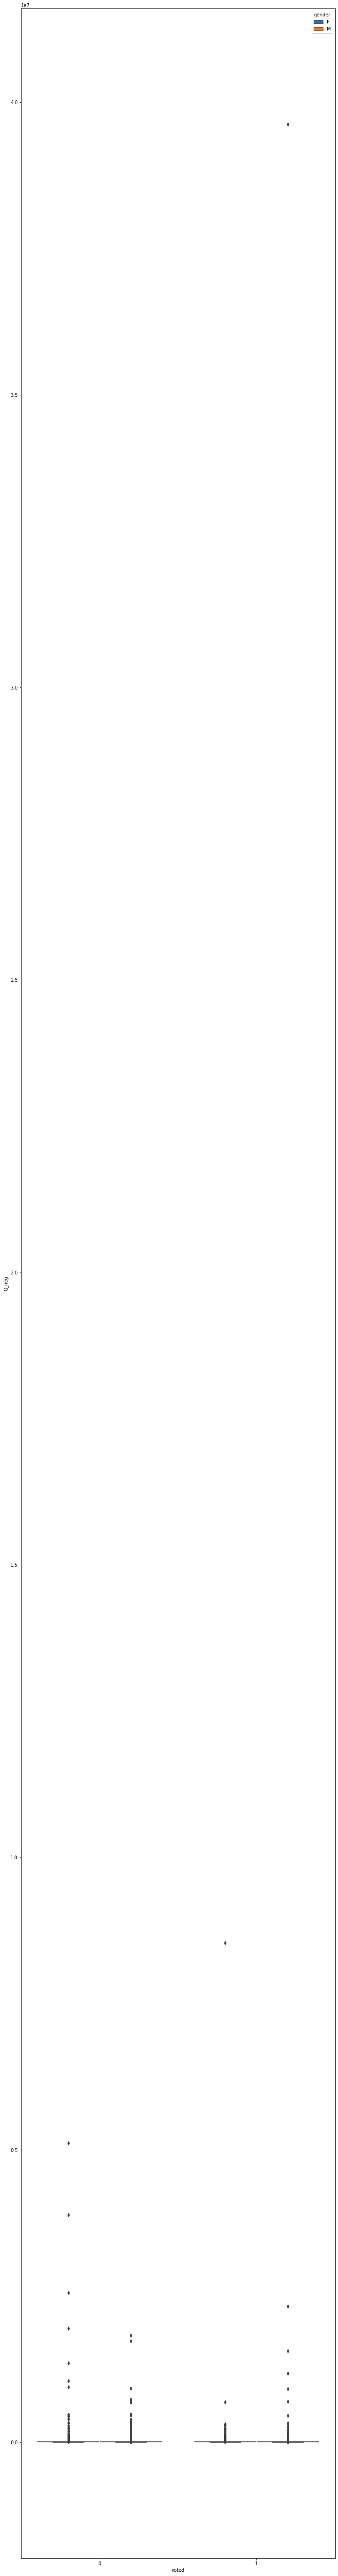

In [28]:
sns.boxplot(data=Q_neg, x ="voted", y = "Q_neg", hue = "gender")

<AxesSubplot:xlabel='voted', ylabel='Q_neg'>

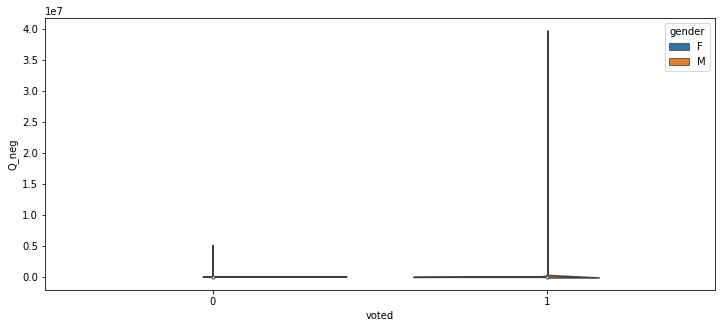

In [29]:
plt.rcParams["figure.figsize"] = (12, 5)
sns.violinplot(data=Q_neg, x ="voted", y = "Q_neg", hue = "gender", split=True)

<AxesSubplot:xlabel='voted', ylabel='Q_neg'>

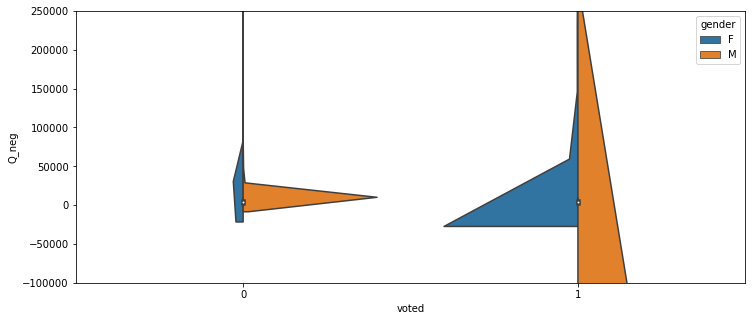

In [30]:
plt.rcParams["figure.figsize"] = (12, 5)
plt.ylim(-100000, 250000)
sns.violinplot(data=Q_neg, x ="voted", y = "Q_neg", hue = "gender", split=True)

- 실제로 -값이 있는지 확인하기 위해 아래와 같이 진행하였지만, drop되는 부분이 없었다. 이는 숫자 범위가 너무 컸기에 발생한 오류로 생각하였다.

In [31]:
Q_neg.drop(Q_neg.loc[Q_neg['Q_neg']<0].index, inplace=True)
Q_neg

/Users/seong-gang/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,Q_neg,voted,gender
0,3227.095,0,F
1,7896.084,0,F
2,6122.784,1,M
3,8842.130,1,F
4,3346.248,1,M
...,...,...,...
45527,1799.617,0,F
45528,4431.475,0,M
45529,4300.286,1,F
45530,3646.933,1,M


- 위를 보면 알 수 있지만, 값의 range가 너무커서 전체에 대해서 데이터 분석을 진행하는 것이 의미가 없다고 생각했고, 튀는 값을 정리하고, 이를 위하여 mean값을 qcut method를 통하여 해석하고자 한다.

In [32]:
Q_neg_data = pd.qcut(Q_neg["Q_neg"], [0, 0.05, 0.25, 0.75, 0.95, 1], labels=["too_short", "short", "middle", "long", "too_long"])
Q_neg["bins"] = Q_neg_data
Q_neg

<ipython-input-32-c2b6fb28652a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Q_neg["bins"] = Q_neg_data


,Q_neg,voted,gender,bins
0,3227.095,0,F,short
1,7896.084,0,F,long
2,6122.784,1,M,long
3,8842.130,1,F,long
4,3346.248,1,M,middle
...,...,...,...,...
45527,1799.617,0,F,too_short
45528,4431.475,0,M,middle
45529,4300.286,1,F,middle
45530,3646.933,1,M,middle


- 남녀 전체에 대해서 진행

In [33]:
neg_short = Q_neg[Q_neg["bins"]=="short"]["voted"].mean()
neg_middle = Q_neg[Q_neg["bins"]=="middle"]["voted"].mean()
neg_long = Q_neg[Q_neg["bins"]=="long"]["voted"].mean()
print("neg_short: ", neg_short, ", neg_middle: ", neg_middle, ", neg_long: ", neg_long)

neg_short:  0.42345706127827804 , neg_middle:  0.4610823157339893 , neg_long:  0.4852844278497694


- 실제로 응답시간이 길어짐에 따라, 투표율이 올라감을 볼 수 있다. 이를 유의수준 5%로 하여 검사하였을 때, 만족함을 알 수 있다.

In [34]:
[t_stat, p] = stats.ttest_ind(Q_neg[Q_neg.bins == 'long'].voted, Q_neg[Q_neg.bins == 'short'].voted)
[t_stat, p]

[8.394413961012138, 5.0213017441156344e-17]

- 여자에 대해서 진행

In [35]:
f_Q_neg = Q_neg[Q_neg["gender"]=="F"]
f_neg_short = f_Q_neg[f_Q_neg["bins"]=="short"]["voted"].mean()
f_neg_middle = f_Q_neg[f_Q_neg["bins"]=="middle"]["voted"].mean()
f_neg_long = f_Q_neg[f_Q_neg["bins"]=="long"]["voted"].mean()
print("female_neg_short: ",f_neg_short, ", female_neg_middle: ", f_neg_middle, ", female_neg_long: ", f_neg_long)

female_neg_short:  0.43563009972801453 , female_neg_middle:  0.46817711760834824 , female_neg_long:  0.4828998073217726


- 실제로 응답시간이 길어짐에 따라, 투표율이 올라감을 볼 수 있다. 이를 유의수준 5%로 하여 검사하였을 때, 만족함을 알 수 있다.

In [36]:
[t_stat, p] = stats.ttest_ind(f_Q_neg[f_Q_neg.bins == 'long'].voted, f_Q_neg[f_Q_neg.bins == 'short'].voted)
[t_stat, p]

[4.3919421360919095, 1.1369342642605075e-05]

- 남자에 대해서 진행

In [37]:
m_Q_neg = Q_neg[Q_neg["gender"]=="M"]
m_neg_short = m_Q_neg[m_Q_neg["bins"]=="short"]["voted"].mean()
m_neg_middle = m_Q_neg[m_Q_neg["bins"]=="middle"]["voted"].mean()
m_neg_long = m_Q_neg[m_Q_neg["bins"]=="long"]["voted"].mean()
print("male_neg_short: ", m_neg_short, ", male_neg_middle: ", m_neg_middle, ", male_neg_long: ", m_neg_long)

male_neg_short:  0.412015338730294 , male_neg_middle:  0.454860252287905 , male_neg_long:  0.4872830036334275


- 실제로 응답시간이 길어짐에 따라, 투표율이 올라감을 볼 수 있다. 이를 유의수준 5%로 하여 검사하였을 때, 만족함을 알 수 있다.

In [38]:
[t_stat, p] = stats.ttest_ind(m_Q_neg[m_Q_neg.bins == 'long'].voted, m_Q_neg[m_Q_neg.bins == 'short'].voted)
[t_stat, p]

[7.447214366460221, 1.0350518769411838e-13]

#### 8) pos data and t test

In [39]:
Q_pos = f_nlu_rate_df[["Q_pos", "voted", "gender"]]
Q_pos.drop(Q_pos.loc[Q_pos['Q_pos']<0].index, inplace=True)
pos_data = pd.qcut(Q_pos["Q_pos"], [0, 0.05, 0.25, 0.75, 0.95, 1], labels=["too_short", "short", "middle", "long", "too_long"])
Q_pos["bins"] = pos_data
Q_pos

/Users/seong-gang/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
<ipython-input-39-e23910b07398>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Q_pos["bins"] = pos_data


,Q_pos,voted,gender,bins
0,2366.062,0,F,short
1,5566.892,0,F,long
2,4022.663,1,M,middle
3,9513.375,1,F,too_long
4,2698.670,1,M,middle
...,...,...,...,...
45527,2280.240,0,F,short
45528,4442.727,0,M,middle
45529,3296.818,1,F,middle
45530,2553.319,1,M,middle


- 남녀 전체에 대해서 진행

In [40]:
pos_short = Q_pos[Q_pos["bins"]=="short"]["voted"].mean()
pos_middle = Q_pos[Q_pos["bins"]=="middle"]["voted"].mean()
pos_long = Q_pos[Q_pos["bins"]=="long"]["voted"].mean()
print("pos_short: ", pos_short, ", pos_middle: ", pos_middle, ", pos_long: ", pos_long)

pos_short:  0.4298264880298704 , pos_middle:  0.4593253096723184 , pos_long:  0.4797935427190863


- 실제로 응답시간이 길어짐에 따라, 투표율이 올라감을 볼 수 있다. 이를 유의수준 5%로 하여 검사하였을 때, 만족함을 알 수 있다.

In [41]:
[t_stat, p] = stats.ttest_ind(Q_pos[Q_pos.bins == 'long'].voted, Q_pos[Q_pos.bins == 'short'].voted)
[t_stat, p]

[6.779022739197963, 1.2470031513704412e-11]

- 여자에 대해서 진행

In [42]:
f_Q_pos = Q_pos[Q_pos["gender"]=="F"]
f_pos_short = f_Q_pos[f_Q_pos["bins"]=="short"]["voted"].mean()
f_pos_middle = f_Q_pos[f_Q_pos["bins"]=="middle"]["voted"].mean()
f_pos_long = f_Q_pos[f_Q_pos["bins"]=="long"]["voted"].mean()
print("female_pos_short: ",f_pos_short, ", female_pos_middle: ", f_pos_middle, ", female_pos_long: ", f_pos_long)

female_pos_short:  0.44106631416611586 , female_pos_middle:  0.4680991423993969 , female_pos_long:  0.47687360870640616


- 실제로 응답시간이 길어짐에 따라, 투표율이 올라감을 볼 수 있다. 이를 유의수준 5%로 하여 검사하였을 때, 만족함을 알 수 있다.

In [43]:
[t_stat, p] = stats.ttest_ind(f_Q_pos[f_Q_pos.bins == 'long'].voted, f_Q_pos[f_Q_pos.bins == 'short'].voted)
[t_stat, p]

[3.325145337019118, 0.0008874319444614855]

- 남자에 대해서 진행

In [44]:
m_Q_pos = Q_pos[Q_pos["gender"]=="M"]
m_pos_short = m_Q_pos[m_Q_pos["bins"]=="short"]["voted"].mean()
m_pos_middle = m_Q_pos[m_Q_pos["bins"]=="middle"]["voted"].mean()
m_pos_long = m_Q_pos[m_Q_pos["bins"]=="long"]["voted"].mean()
print("male_pos_short: ", m_pos_short, ", male_pos_middle: ", m_pos_middle, ", male_pos_long: ", m_pos_long)

male_pos_short:  0.41865557258594266 , male_pos_middle:  0.4516659810777458 , male_pos_long:  0.48212522220027654


- 실제로 응답시간이 길어짐에 따라, 투표율이 올라감을 볼 수 있다. 이를 유의수준 5%로 하여 검사하였을 때, 만족함을 알 수 있다.

In [45]:
[t_stat, p] = stats.ttest_ind(m_Q_pos[m_Q_pos.bins == 'long'].voted, m_Q_pos[m_Q_pos.bins == 'short'].voted)
[t_stat, p]

[6.261062827627665, 3.98685616828113e-10]

#### 9) neu data and t test

In [46]:
Q_neu = f_nlu_rate_df[["Q_neu", "voted", "gender"]]
Q_neu.drop(Q_neu.loc[Q_neu['Q_neu']<0].index, inplace=True)
neu_data = pd.qcut(Q_neu["Q_neu"], [0, 0.05, 0.25, 0.75, 0.95, 1], labels=["too_short", "short", "middle", "long", "too_long"])
Q_neu["bins"] = neu_data
Q_neu

/Users/seong-gang/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
<ipython-input-46-251e3d7d3175>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Q_neu["bins"] = neu_data


,Q_neu,voted,gender,bins
0,7977.745,0,F,short
1,18753.329,0,F,long
2,13830.558,1,M,middle
3,33151.212,1,F,too_long
4,8904.379,1,M,middle
...,...,...,...,...
45527,6291.988,0,F,short
45528,12109.547,0,M,middle
45529,10624.660,1,F,middle
45530,8246.211,1,M,middle


- 남녀 전체에 대해서 진행

In [47]:
neu_short = Q_neu[Q_neu["bins"]=="short"]["voted"].mean()
neu_middle = Q_neu[Q_neu["bins"]=="middle"]["voted"].mean()
neu_long = Q_neu[Q_neu["bins"]=="long"]["voted"].mean()
print("neu_short: ", neu_short, ", neu_middle: ", neu_middle, ", neu_long: ", neu_long)

neu_short:  0.42521414452009665 , neu_middle:  0.4602477378546956 , neu_long:  0.486053151768065


- 실제로 응답시간이 길어짐에 따라, 투표율이 올라감을 볼 수 있다. 이를 유의수준 5%로 하여 검사하였을 때, 만족함을 알 수 있다.

In [48]:
[t_stat, p] = stats.ttest_ind(Q_neu[Q_neu.bins == 'long'].voted, Q_neu[Q_neu.bins == 'short'].voted)
[t_stat, p]

[8.257816044196595, 1.5841091384947825e-16]

- 여자에 대해서 진행

In [49]:
f_Q_neu = Q_neu[Q_neu["gender"]=="F"]
f_neu_short = f_Q_neu[f_Q_neu["bins"]=="short"]["voted"].mean()
f_neu_middle = f_Q_neu[f_Q_neu["bins"]=="middle"]["voted"].mean()
f_neu_long = f_Q_neu[f_Q_neu["bins"]=="long"]["voted"].mean()
print("female_neu_short: ",f_neu_short, ", female_neu_middle: ", f_neu_middle, ", female_neu_long: ", f_neu_long)

female_neu_short:  0.43708165997322623 , female_neu_middle:  0.46947427925381574 , female_neu_long:  0.481201171875


- 실제로 응답시간이 길어짐에 따라, 투표율이 올라감을 볼 수 있다. 이를 유의수준 5%로 하여 검사하였을 때, 만족함을 알 수 있다.

In [50]:
[t_stat, p] = stats.ttest_ind(f_Q_neu[f_Q_neu.bins == 'long'].voted, f_Q_neu[f_Q_neu.bins == 'short'].voted)
[t_stat, p]

[4.10000957390779, 4.169456968014811e-05]

- 남자에 대해서 진행

In [51]:
m_Q_neu = Q_neu[Q_neu["gender"]=="M"]
m_neu_short = m_Q_neu[m_Q_neu["bins"]=="short"]["voted"].mean()
m_neu_middle = m_Q_neu[m_Q_neu["bins"]=="middle"]["voted"].mean()
m_neu_long = m_Q_neu[m_Q_neu["bins"]=="long"]["voted"].mean()
print("male_neu_short: ", m_neu_short, ", male_neu_middle: ", m_neu_middle, ", male_neu_long: ", m_neu_long)

male_neu_short:  0.41371107266435986 , male_neu_middle:  0.4521889400921659 , male_neu_long:  0.49001996007984033


- 실제로 응답시간이 길어짐에 따라, 투표율이 올라감을 볼 수 있다. 이를 유의수준 5%로 하여 검사하였을 때, 만족함을 알 수 있다.

In [52]:
[t_stat, p] = stats.ttest_ind(m_Q_neu[m_Q_neu.bins == 'long'].voted, m_Q_neu[m_Q_neu.bins == 'short'].voted)
[t_stat, p]

[7.53800869546061, 5.202613301720859e-14]

#### 10) total data and test

In [53]:
np_data_whole = np.zeros((45532, 1))
whole = pd.DataFrame(columns=["time"], data = np_data_whole)
for i in list(nlu_rate_df.columns):
    whole["time"] += nlu_rate_df[i] 
whole["time"] = whole["time"] / 3
whole_data = pd.qcut(whole["time"], [0, 0.05, 0.25, 0.75, 0.95, 1], labels=["too_short", "short", "middle", "long", "too_long"])
whole["bins"] = whole_data
whole["voted"] = np.where(data["voted"]==1, 1, 0)
whole["gender"] = np.where(data["gender"]=="Female", "F", "M")
whole

,time,bins,voted,gender
0,4523.634000,short,0,F
1,10738.768333,long,0,F
2,7992.001667,middle,1,M
3,17168.905667,too_long,1,F
4,4983.099000,middle,1,M
...,...,...,...,...
45527,3457.281667,short,0,F
45528,6994.583000,middle,0,M
45529,6073.921333,middle,1,F
45530,4815.487667,middle,1,M


- 남녀 전체에 대해서 진행

In [54]:
short = whole[whole["bins"]=="short"]["voted"].mean()
middle = whole[whole["bins"]=="middle"]["voted"].mean()
long = whole[whole["bins"]=="long"]["voted"].mean()
print("whole_short: ", short, ", whole_middle: ", middle, ", whole_long: ", long)

whole_short:  0.4262025038436196 , whole_middle:  0.4589299833084424 , whole_long:  0.4866022402811333


- 실제로 응답시간이 길어짐에 따라, 투표율이 올라감을 볼 수 있다. 이를 유의수준 5%로 하여 검사하였을 때, 만족함을 알 수 있다.

In [55]:
[t_stat, p] = stats.ttest_ind(whole[whole.bins == 'long'].voted, whole[whole.bins == 'short'].voted)
[t_stat, p]

[8.196850585353042, 2.6298482895841996e-16]

- 여자에 대해서 진행

In [56]:
f_whole = whole[whole["gender"]=="F"]
f_whole_short = f_whole[f_whole["bins"]=="short"]["voted"].mean()
f_whole_middle = f_whole[f_whole["bins"]=="middle"]["voted"].mean()
f_whole_long = f_whole[f_whole["bins"]=="long"]["voted"].mean()
print("female_short: ",f_whole_short, ", female_middle: ", f_whole_middle, ", female_whole_long: ", f_whole_long)

female_short:  0.4396340102655657 , female_middle:  0.4670878913617503 , female_whole_long:  0.4818602386169954


- 실제로 응답시간이 길어짐에 따라, 투표율이 올라감을 볼 수 있다. 이를 유의수준 5%로 하여 검사하였을 때, 만족함을 알 수 있다.

In [57]:
[t_stat, p] = stats.ttest_ind(f_whole[f_whole.bins == 'long'].voted, f_whole[f_whole.bins == 'short'].voted)
[t_stat, p]

[3.9251938971773677, 8.733684377707702e-05]

- 남자에 대해서 진행

In [58]:
m_whole = whole[whole["gender"]=="M"]
m_whole_short = m_whole[m_whole["bins"]=="short"]["voted"].mean()
m_whole_middle = m_whole[m_whole["bins"]=="middle"]["voted"].mean()
m_whole_long = m_whole[m_whole["bins"]=="long"]["voted"].mean()
print("male_short: ", m_whole_short, ", male_middle: ", m_whole_middle, ", male_long: ", m_whole_long)

male_short:  0.4131891891891892 , male_middle:  0.4518171353395823 , male_long:  0.49049809961992397


- 실제로 응답시간이 길어짐에 따라, 투표율이 올라감을 볼 수 있다. 이를 유의수준 5%로 하여 검사하였을 때, 만족함을 알 수 있다.

In [59]:
[t_stat, p] = stats.ttest_ind(m_whole[m_whole.bins == 'long'].voted, m_whole[m_whole.bins == 'short'].voted)
[t_stat, p]

[7.6338583534198925, 2.495051155390826e-14]

#### 11) long한 친구들끼리 비교, 시각화

In [60]:
result_dict = {
    "type": ['whole_long', 'whole_long', 'pos_long', 'pos_long', 'neu_long', 'neu_long', 'neg_long', 'neg_long'], 
    "gender": ['F', 'M', 'F', 'M', 'F', 'M', 'F', 'M'],
    "mean": [f_whole_long, m_whole_long, f_pos_long, m_pos_long, f_neu_long, m_neu_long, f_neg_long, m_neg_long]
}
result_df = pd.DataFrame(result_dict)
result_df

,type,gender,mean
0,whole_long,F,0.481860
1,whole_long,M,0.490498
2,pos_long,F,0.476874
3,pos_long,M,0.482125
4,neu_long,F,0.481201
5,neu_long,M,0.490020
6,neg_long,F,0.482900
7,neg_long,M,0.487283


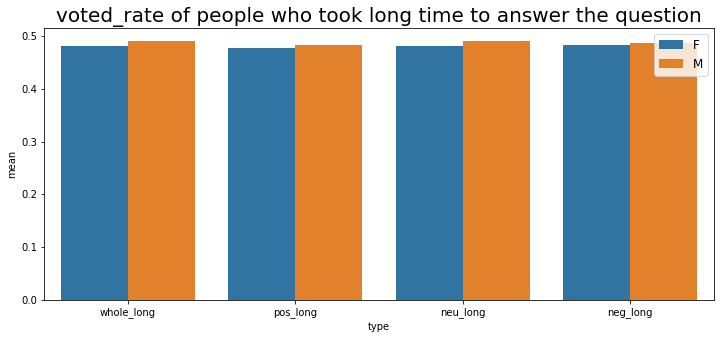

In [61]:
sns.barplot(x='type', y='mean', hue='gender', data=result_df) 
plt.title('voted_rate of people who took long time to answer the question', fontsize=20)
plt.legend(fontsize=12)
plt.show()

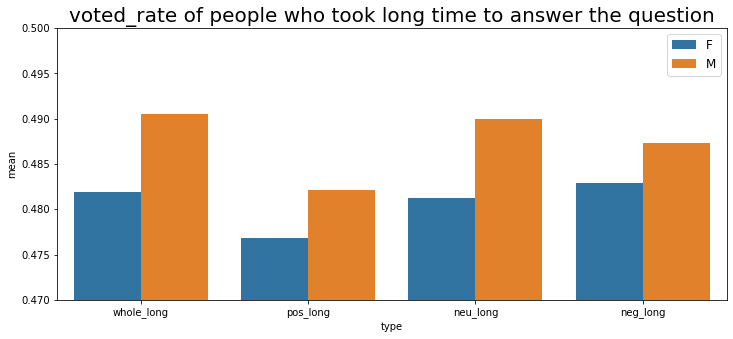

In [62]:
sns.barplot(x='type', y='mean', hue='gender', data=result_df) 
plt.title('voted_rate of people who took long time to answer the question', fontsize=20)
plt.ylim(0.47, 0.5)
plt.legend(fontsize=12)
plt.show()

### 4. 결론 및 고찰
1. 엄청 큰 차이는 아니었지만, 확 튀는 값들을 제외해준 후에, 질문에 답변하는데 걸리는 시간을 3분위로 나누어서 확인해 보았을 때, 질문을 답하는데 걸리는 시간이 클수록, 투표율이 올라감을 볼 수 있었다.
2. 남성의 경우에는 부정적인 질문에 대해 오래 고민한 사람이 투표율이 컸으며, 여성의 경우에는 긍정적인 질문에 대해 오래 고민한 사람이 투표율이 컸다.  
3. 또한 남성의 경우에 질문에 대해 오래 고민한 사람과 짧게 고민한 사람간의 차이가 약 8%정도로 가장 컸다.
4. 모든 분석에 대해 p값이 낮게 나오는 것이 인상적이었으며, 이는 샘플 사이즈가 매우 컸던 이유도 있다고 생각한다.
5. nlu 자체에 대한 만족도는 높지 않았으며, 추후에 하게 된다면, nlu 파트에 대한 더욱 세분화, 구체화가 된다면 더 좋은 탐구가 되었을 것으로 예상한다.
6. 심리검사에 대답하는 사람들의 답변이 아니라 단순히 걸리는 시간 만으로도 이렇게 유의미한 차이가 난다는 것이 신기하였다. 

---------------

### 5. 출처
데이터 출처: openpsychometrics.org